# HW3 CS454 CAN SÖLÖMBAZ

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import math
import itertools

In [2]:
train_data=pd.read_csv("C:/Users/mrt/Desktop/downloads/training25.csv",header=None)
test_data=pd.read_csv("C:/Users/mrt/Desktop/downloads/test25.csv",header=None)
validation_data=pd.read_csv("C:/Users/mrt/Desktop/downloads/validation25.csv",header=None)

In [3]:
train_data.head()

,0,1
0,-3.00,-0.131883
1,-2.48,0.319268
2,-1.96,0.388196
3,-1.44,0.611449
4,-0.92,0.801638


In [4]:
x_train=train_data.iloc[:,0].values
r_train=train_data.iloc[:,1].values
x_test=test_data.iloc[:,0].values
r_test=test_data.iloc[:,1].values
x_validation=validation_data.iloc[:,0].values
r_validation=validation_data.iloc[:,1].values
x_validation

array([-2.82666667, -2.30666667, -1.78666667, -1.26666667, -0.74666667,
       -0.22666667,  0.29333333,  0.81333333,  1.33333333,  1.85333333,
        2.37333333,  2.89333333,  3.41333333,  3.93333333,  4.45333333,
        4.97333333,  5.49333333,  6.01333333,  6.53333333,  7.05333333,
        7.57333333,  8.09333333,  8.61333333,  9.13333333,  9.65333333])

## Polynomial Regression

$r = f(x) + Ɛ$

$p(r|x) \sim g(x|θ),σ²)$ if Ɛ is zero mean Gaussian and constant variance σ² and f is estimated with function g

To learn parameters, we use mle for joint probability density p(x,r) and parameters are found with
minimizing error function 

$E(θ|x)=\sum_{t=1}^N [r^t- g(x^t|θ)]^2$

$g(x^t|w_k,..w_1,w_0) = w_k(x^t)^k+..+w_1x^t+w_0$

taking derivative of sum squared errors $w=(D^TD)^{-1}D^Tr$

In [38]:
def mean_square_error(y_pred,y_true):
    mse=0
    for i in range(len(y_pred)):
        mse+=(y_pred[i]-y_true[i])**2
    mse=mse/len(y_pred)
    return mse

In [60]:
def find_params(x_data,r_data,K):
    w_all=[]
    for k in range(1,K+1): 
        D=np.zeros([len(x_data),k+1])
        D[:,0]=1
        for i in range(len(x_data)):
            for j in range(k):
                D[i,j+1]=x_data[i]**(j+1)
        w=inv(np.transpose(D).dot(D)).dot(np.transpose(D)).dot(r_data)
        w_all.append(w)
    
    return w_all

In [59]:
def regressor(w_all,x_data,r_data,K):
    all_mse=[]
    all_y_pred=[]
    
    for k in range(K):
        w=w_all[k]
        y_pred=[]
        for i in range(len(x_data)):
            y=0
            for j in range(k+2):
                y+=w[j]*(x_data[i]**j)
            y_pred.append(y)
            
        all_y_pred.append(y_pred) 
        all_mse.append(mean_square_error(y_pred,r_data))
        
    return all_mse

In [72]:
K=12
w_all = find_params(x_train,r_train,K)
validation_errors = regressor(w_all, x_validation, r_validation,K)
train_errors=regressor(w_all,x_train,r_train,K)

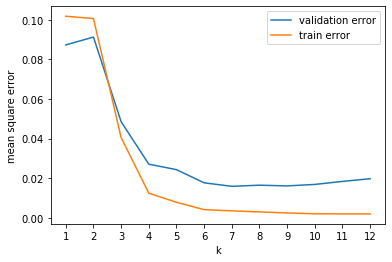

In [159]:
def plt_error(validation_errors,train_errors,K):
    num_k=[k for k in range(1,K+1)] 
    plt.plot(num_k,validation_errors, label="validation error")
    plt.plot(num_k,train_errors, label="train error")
    plt.legend(loc="upper right")
    plt.xlabel("k")
    plt.ylabel("mean square error")
    plt.xticks(num_k)
    plt.show()
plt_error(validation_errors,train_errors,K)

In [108]:
best_k=validation_errors.index(min(validation_errors))+1
best_k

7

In [109]:
w_all[best_k-1]

array([ 9.53523422e-01, -3.82458522e-03, -1.45989287e-01,  4.27544836e-03,
        5.24532999e-03, -1.36461991e-04, -8.80007818e-05,  5.87622237e-06])

According to validation data errors, k=7 is the best hyperparameter (k=7 means seventh degree polynomial)
Now, I will calculate the test errors using k=7

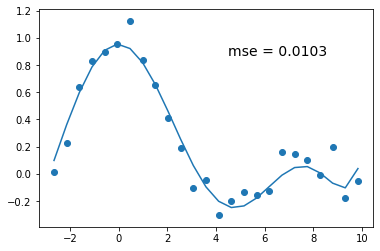

In [110]:
def test_error(x_test,r_test,w_all,k):
    w=w_all[k-1]
    y_pred=[]
    for i in range(len(x_test)):
        y=0
        for j in range(k+1):
            y+=w[j]*(x_test[i]**j)
        y_pred.append(y)
            
    mse=mean_square_error(y_pred,r_test)
    
    plt.scatter(x_test,r_test)
    plt.plot(x_test,y_pred)
    text="mse = "+"%.4f" %mse
    plt.text(4.5, 0.95, text, fontsize=14, verticalalignment='top')
    
    return plt.show()
test_error(x_test,r_test,w_all,best_k)

## K-NN Regression



In [140]:
def distance(point1, point2):
    sum_squared_dist = math.pow(point1 - point2, 2)
    return math.sqrt(sum_squared_dist)

In [179]:
def knn_regressor(train_x, test_x, train_y, test_y,K):
    y_predicted=np.empty((len(train_x),K),dtype=np.float32)
    mse=[]

    for i in range(len(test_x)):          
        neighbors_dist=[]
        for j in range(len(train_x)):
            dist=distance(test_x[i],train_x[j])
            neighbors_dist.append((dist,train_y[j]))  
            
        knn=sorted(neighbors_dist, key=lambda x: x[0])[:K] #sort neighbors according to distances and select nearest K
           
        for k in range(K):
            mean=0
            for m in range(k+1):
                mean+=knn[m][1]
            mean=mean/(k+1)
                
            y_predicted[i,k]=mean # mean of k nearest neighbors our prediction, prediction for k=1 to K    
        
    y_predicted=pd.DataFrame(y_predicted)    
    
    for n in range(K):
        mse.append(mean_square_error(y_predicted.iloc[:,n], test_y))
    
    return mse,y_predicted


In [180]:
validation_error,y_pred_val = knn_regressor(x_train, x_validation, r_train, r_validation,10)  
train_error,y_pred_train = knn_regressor(x_train, x_train, r_train, r_train,10)  

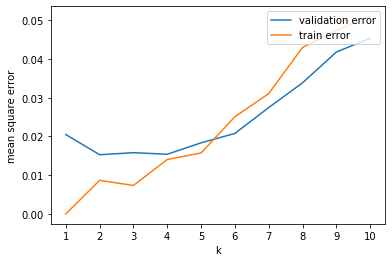

In [181]:
plt_error(validation_error,train_error,10)

In [182]:
best_k=validation_error.index(min(validation_error))+1
best_k

2

In [190]:
test_error,y_pred_test=knn_regressor(x_train, x_test, r_train, r_test, 2)
test_error=test_error[1]
y_pred_test=y_pred_test[1]

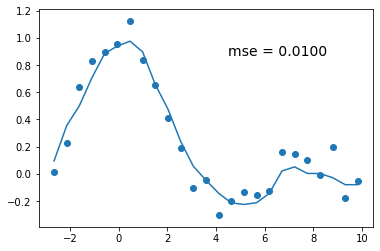

In [193]:
plt.scatter(x_test,r_test)
plt.plot(x_test,y_pred_test)
text="mse = "+"%.4f" %test_error
plt.text(4.5, 0.95, text, fontsize=14, verticalalignment='top')
plt.show()

## Multi Layer Perceptron

Since the problem is not linearly seperable, mlp should be used to perform a nonlinear regression

Network was designed as one output and one input and number of hidden units

I used batch gradient descent to find parameters

$ y^t = \sum_{h=1}^H v_hz_h^t+v_0$ 

$ z_h = sigmoid(w_h^tx) $

$ E(w,v|X) = 0.5\sum_{t=1}^N (r^t-y^t)^2 $

$\Delta v_h = \alpha \sum_{t=1}^N (r^t-y^t)z_h^t$

$ \Delta w_hj = \alpha \sum_{t=1}^N (r^t-y^t)v_h z_h^t (1-z_h^t) x_j^t $

In [6]:
def mlp_params(alpha, number_of_H, x_train, r_train):

    w_all=[]
    v_all=[]
    for H in range (2,number_of_H+1):
        
        # initialize parameters
        x=np.ones((2,len(x_train)))
        x[1,:]=x_train
        v=np.random.uniform(-0.01,0.01,size=(H))#v_h
        w=np.random.uniform(-0.01,0.01,size=(H-1,len(x))) #w_hj      
        z=1/(1+np.exp(-(w.dot(x))))
        y=v[1:].dot(z)+v[0]
        
        epoch=0
        
        while True:
        
            delta_v=np.empty(H)
            
            sum_v0=0
            for i in range(len(x_train)):
                    sum_v0+=(r_train[i]-y[i])
            delta_v[0]=alpha*sum_v0        
            for h in range(H-1):
                sum_1=0
                for i in range(len(x_train)):
                    sum_1+=(r_train[i]-y[i])*z[h,i]
                delta_v[h+1]=alpha*sum_1
            
            
            
            delta_w=np.empty((H-1,len(x)))
            
            for h in range(H-1):  
                for j in range(len(x)):
                    sum_2=0
                    for i in range(len(x_train)):
                        sum_2+=(r_train[i]-y[i])*v[1:][h]*z[h,i]*(1-z[h,i])*x[j,i]
                    delta_w[h,j]=alpha*sum_2
            
            
            temp_v=v
            v=np.add(v,delta_v,dtype=np.float64)
            
            
            temp_w=w      
            w=np.add(w,delta_w,dtype=np.float64)
            
    
            
            z=1/(1+np.exp(-(w.dot(x))))
            y=v[1:].dot(z)+v[0]
            
   
            epoch=epoch+1
            
            
            
            if (all(x <0.0001 for x in itertools.chain(*delta_w))) and (all(x <0.0001 for x in (delta_v))):
                w_all.append(w)
                v_all.append(v)
                break
    
    return w_all,v_all
    

In [7]:
w_all, v_all = mlp_params(0.01,10,x_train,r_train)

In [14]:
all(x <0.0001 for x in (w_all[0]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
w_all[0]

array([[ 5.62812045, -2.33727886]])

In [62]:
def mlp_results(w_all, v_all, x_data, r_data, number_of_H):
    
    all_mse=[]
    y_all=[]
    for H in range (number_of_H-1):
        
        x=np.ones((2,len(x_data)))
        x[1,:]=x_data
        z=1/(1+np.exp(-(w_all[H].dot(x))))
        y=v_all[H][1:].dot(z)+v_all[H][0]
        
        y_all.append(y)
        all_mse.append(mean_square_error(y,r_data))
        
    return all_mse,y_all

In [75]:
train_errors_mlp,y_train = mlp_results(w_all, v_all, x_train, r_train, 10)
validation_errors_mlp,y_validation = mlp_results(w_all, v_all, x_validation, r_validation, 10)

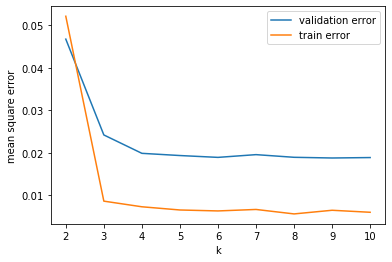

In [76]:
def plt_error(validation_errors,train_errors,H):
    num_k=[k for k in range(2,H+1)] 
    plt.plot(num_k,validation_errors, label="validation error")
    plt.plot(num_k,train_errors, label="train error")
    plt.legend(loc="upper right")
    plt.xlabel("k")
    plt.ylabel("mean square error")
    plt.xticks(num_k)
    plt.show()
plt_error(validation_errors_mlp,train_errors_mlp,10)

In [58]:
best_k=validation_errors_mlp.index(min(validation_errors_mlp))+1
best_k

8

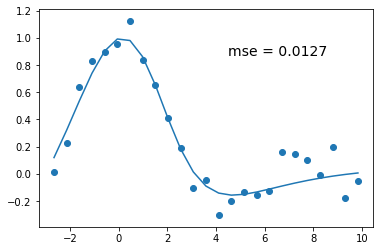

In [77]:
test_errors_mlp,y_test = mlp_results(w_all, v_all, x_test, r_test, 10)
plt.scatter(x_test,r_test)
plt.plot(x_test,y_test[6])
text="mse = "+"%.4f" %test_errors_mlp[6]
plt.text(4.5, 0.95, text, fontsize=14, verticalalignment='top')
plt.show()